# Operadores creación y destrucción fermiónicos

La idea principal de este programa es crear los operadores creación y destrucción fermiónicos a partir de los bosónicos, ya que $\textit{Qutip}$ solo te proporciona los operadores creación y destrucción bosónicos.

Y con los operadores fermiónicos resolver el Hamiltoniano de Hubbard.

$$\hat{H}=\sum_{mn\sigma} t_{mn}\hat{d}_{m\sigma}^\dagger\hat{d}_{n\sigma} +\sum_m v_m \hat{n}_{m}+\sum_m U \hat{n}_{m\uparrow} \hat{n}_{m\downarrow} $$

In [1]:
%matplotlib inline
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations
from time import time

La metodología para crear los operadores creación y destrucción es componer los operadores $\textit{create(2)/destroy(2)}$ con la matriz de Pauli, $\sigma_3$ y las identidades, $\mathcal{1}$ de la siguiente forma:

$$
d^F_{1\downarrow}=d^B_{1\downarrow}\otimes\mathcal{1}
\otimes\mathcal{1}\otimes\mathcal{1}\\
d^F_{1\uparrow}=\sigma_3\otimes d^B_{1\uparrow}\otimes\mathcal{1}
\otimes\mathcal{1}\\
d^F_{2\downarrow}=\sigma_3\otimes\sigma_3\otimes d^B_{2\downarrow}\otimes\mathcal{1}\\
d^F_{2\uparrow}=\sigma_3\otimes\sigma_3\otimes\sigma_3\otimes d^B_{2\uparrow}
$$

Todos los operadores bosónicos son el mismo $\textit{create(2)/destroy(2)}$
dependiendo de la posición que tome crea o destruye el estado que hayamos asociado.

In [2]:

def Is(i): return [qeye(2) for j in range(0, i)]
def b(i): return [basis(2,0) for j in range(0, i)]
def sigz(i): return[sigmaz() for j in range(0,i)]
def d(N,i): return tensor(sigz(i)+[destroy(2)]+ Is(N-i-1))

In [3]:
def factorial(n):
    productoria = 1
    for i in range(2, n+1):
        productoria *= i
    return productoria

In [4]:
def combinatorio(n, k):
    return factorial(n)//(factorial(n-k)*factorial(k)) 

In [5]:
def base_comp(Sites, N_electrones):
    q=b(2*Sites)
    for i in range(0,N_electrones):
        q[i]=create(2)*q[i]
    return list(multiset_permutations(q))

In [6]:
def n_operator(sites, n_electrones):
    n=[[0 for x in range(2)] for y in range (sites)]
    l=0
    for i in range(sites):
        for j in range(2):
            n[i][j]=d(2*sites,l).dag()*d(2*sites,l)
            l+=1
    
    return n

Cálculo del término cinético:

$$\hat{T}=\sum_{mn\sigma} t_{mn}\hat{d}_{m\sigma}^\dagger\hat{d}_{n\sigma}$$

In [7]:
def kinetic(t, sites):
    
    T=0
    
    for i in range (0,2*sites):
        for j in range (0,2*sites):
            T+=t[i][j]*d(2*sites,i).dag()*d(2*sites,j)
            
    return T

Cálculo del término del potencial externo:

$$\hat{V}=\sum_m v_m \hat{n}_{m}$$

In [8]:
def local_potential(v,sites):
    V=0
    l=0
    for i in range(sites):
        for j in range (2):
            V+=v[i]*d(2*sites,l).dag()*d(2*sites,l)
            l+=1
    return V    

Cálculo del término de interacción:

$$\hat{W}=\sum_m U \hat{n}_{m\uparrow} \hat{n}_{m\downarrow}$$

In [9]:
def two_body(U, sites):
    S=0
    
    for i in range(sites):
        S+=U*d(2*sites, 2*i).dag()*d(2*sites, 2*i)*d(2*sites, 2*i+1).dag()*d(2*sites, 2*i+1)
    return S

En esta sección damos los valores del sistema.

In [10]:
N_e=2
P=2
t = [[0 for x in range(2*P)] for y in range(2*P)]
v=np.zeros(P)
for i in range (0, 2*P-2):
    t[i][i+2]=t[i+2][i]=-0.5
            
v_1=np.linspace(0, 10, 50)

U=[0.2, 1., 2., 5., 10.]

En esta sección de código preparamos las matrices para restringir al subespacio que queremos. 

In [11]:
A=0

base_total=base_comp(P,N_e)
base_fisica=[]

for i in range (combinatorio(2*P,N_e)):
    A+=tensor(base_total[i])*basis(combinatorio(2*P,N_e),i).dag()


Y finalmente, resolvemos el Hamiltoninao para los diferentes valores de $\Delta v$ y $U$.

In [12]:
t_0=time()

E=[]
delta_N=[]
n=n_operator(P,N_e)

h_1=kinetic(t,P)
for j in range (0,len(U)):
    
    e=[]
    delta_n=[]
    h_2=two_body(U[j],P)
    
    for k in range (0, len(v_1)):
    
        for i in range (0,P):
            v[i]=(-1)**i*v_1[k]
            
        h_3=local_potential(v,P)
        H=h_1+h_2+h_3
        H_2=A.dag()*H*A
        evals, ekets= H_2.eigenstates()
        e.append(evals[0])
        delta_n.append(abs((A.dag()*(n[0][0]+n[0][1])*A-A.dag()*(n[1][0]+n[1][1])*A).matrix_element(ekets[0],ekets[0])))
        
    E.append(e)
    delta_N.append(delta_n)
    
data = np.column_stack([E[0], E[1], E[2], E[3], E[4]])
np.savetxt('Energia_exacta.txt' , data, fmt=['%.8f','%.8f','%.8f','%.8f','%.8f']) 
t_1=time()-t_0
t_1

1.8764197826385498

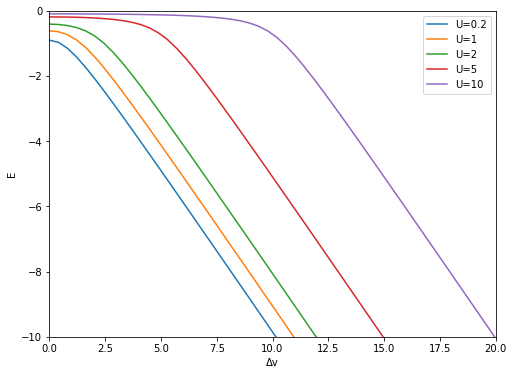

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

plt.ylim(-10, 0)
plt.xlim(0, 20)

ax.plot(2*v_1, E[0])
ax.plot(2*v_1, E[1])
ax.plot(2*v_1, E[2])
ax.plot(2*v_1, E[3])
ax.plot(2*v_1, E[4])
ax.legend(("U=0.2", "U=1", "U=2", "U=5", "U=10"))
ax.set_xlabel('Δv')
ax.set_ylabel('E')

plt.show()

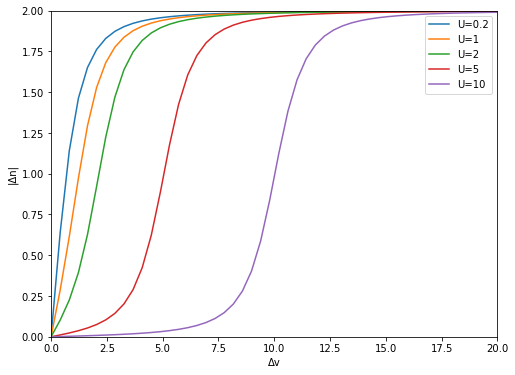

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

plt.ylim(0, 2)
plt.xlim(0, 20)

ax.plot(2*v_1, delta_N[0])
ax.plot(2*v_1, delta_N[1])
ax.plot(2*v_1, delta_N[2])
ax.plot(2*v_1, delta_N[3])
ax.plot(2*v_1, delta_N[4])
ax.legend(("U=0.2", "U=1", "U=2", "U=5", "U=10"))
ax.set_xlabel('Δv')
ax.set_ylabel('|Δn|')

plt.show()